In [72]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
import access_spectrum as acs
import run_empca
reload(run_empca)
from run_empca import *
import polyfit as pf
silent=False
# Remember, the windows are the INVERSE of the absorption features

Populating the interactive namespace from numpy and matplotlib


In [73]:
windowinfo = 'pickles/windowinfo.pkl'
elemwindows,window_all,window_peak,windowPeaks,windowPixels,tophats = acs.pklread(windowinfo)

In [74]:
specs = acs.pklread('red_clump/pickles/spectra_FE_H_u-0.4_d-0.5.pkl')[0]

In [75]:
errs = acs.pklread('red_clump/pickles/errs_FE_H_u-0.4_d-0.5.pkl')

In [76]:
SNR = specs/errs

In [77]:
vec = np.tile(elemwindows['C']+elemwindows['Al'],(specs.shape[0],1))

In [78]:
falsespecs = np.ma.masked_array(vec,specs.mask)

In [79]:
noise = falsespecs/SNR

In [80]:
drawn_noise = noise*np.random.randn(noise.shape[0],noise.shape[1])

In [81]:
falsespecs += drawn_noise

In [82]:
falsespecs.mask[np.where(noise<1e-10)] = True
noise.mask[np.where(noise<1e-10)] = True

In [101]:
def vec_weight(elem,vec):
    w = elemwindows[elem]
    nw = np.ma.masked_array(pf.normweights(w))
    return np.ma.sum(nw*vec)
    
def arr_weight(elem,arr):
    w = elemwindows[elem]
    nw = np.ma.masked_array(pf.normweights(w))
    nws = np.tile(nw,(arr.shape[0],1))
    return np.ma.sum(nws*arr,axis=1)
    
def test_run(specs,noise,deltR2=2e-3,nvecs=5,mad=True,maxvec=5):
    m1,m2,w1,w2 = pix_empca(None,specs.T,noise,'test.pkl',nvecs=nvecs,deltR2=2e-3,gen=True,usemad=mad)
    R2_1 = R2(m1) #must be here (and not below resize) to avoid error
    R2_2 = R2(m2)
    R2_noise2 = R2noise(w2,m2,usemad=mad)
    resize_pix_eigvecs(specs.T,m1,nstars=5)
    resize_pix_eigvecs(specs.T,m2,nstars=5)
    m1elem = np.zeros((nvecs,len(elems)))
    m2elem = np.zeros((nvecs,len(elems)))
    specs_weight = np.ma.masked_array(np.zeros((len(elems),specs.shape[0])))
    noise_weight = np.ma.masked_array(np.zeros((len(elems),specs.shape[0])))
    for ind in range(len(elems)):
        specs_weight[ind] = arr_weight(elems[ind],specs)
        noise_weight[ind] = arr_weight(elems[ind],noise)
        for vec in range(nvecs):
            m1elem[vec][ind] = vec_weight(elems[ind],m1.eigvec[vec])
            m2elem[vec][ind] = vec_weight(elems[ind],m2.eigvec[vec])
    specs_weight.mask[np.where(noise_weight<1e-10)] = True
    noise_weight.mask[np.where(noise_weight<1e-10)] = True
    m3,m4,w3,w4 = elem_empca(None,specs_weight,noise_weight,'test2.pkl',nvecs=nvecs,gen=True,deltR2=2e-3,usemad=mad)        
    R2_3 = R2(m3)
    R2_4 = R2(m4)
    R2_noise4 = R2noise(w4,m4,usemad=mad)
    resize_pix_eigvecs(specs_weight,m3,nstars=5,dim2=len(elems))
    resize_pix_eigvecs(specs_weight,m4,nstars=5,dim2=len(elems))
    for n in range(maxvec):
        plt.figure(figsize=(12,3))
        plt.axhline(0,linestyle='--',color='k',linewidth=3)
        plt.plot(norm_eigvec(m1elem[n]),'o',markersize=8)
        plt.plot(norm_eigvec(m2elem[n]),'o',markersize=8)
        plt.plot(norm_eigvec(m3.eigvec[n]),'o',markersize=8)
        plt.plot(norm_eigvec(m4.eigvec[n]),'o',markersize=8)
        plt.xticks(range(len(elems)),elems)
        plt.ylabel('Eigenvenctor {0}'.format(n+1))
        plt.xlim(-1,len(elems)+1)
    plt.figure(figsize=(12,3))
    plt.plot(R2_1,marker='o',linewidth = 3,markersize=8)
    plt.plot(R2_2,marker='o',linewidth = 3,markersize=8)
    plt.axhline(R2_noise2,linestyle='--',color='b',linewidth=3,label='R2n_pix = {0:2f}'.format(R2_noise2))
    plt.fill_between(range(nvecs),R2_noise2,1,color='b',alpha=0.2)
    plt.plot(R2_3,marker='o',linewidth = 3,markersize=8)
    plt.plot(R2_4,marker='o',linewidth = 3,markersize=8)
    plt.axhline(R2_noise4,linestyle='--',color='r',linewidth=3,label='R2n_pix = {0:2f}'.format(R2_noise4))
    plt.fill_between(range(nvecs),R2_noise4,1,color='r',alpha=0.2)
    plt.legend(loc='best')

       iter        R2             rchi2
EMPCA  1/25       0.00000004  26414.14436873
R2: 0.999891720051
var, Vnoise  0.00529054163069 2.07939536632e-06
(846, 6)
       iter        R2             rchi2
EMPCA  1/25     -52.89024978 160701781848955.15625000
EMPCA  2/25       0.95717643 150142715545.96600342
EMPCA  3/25       0.99886830 37677986028.80741882
EMPCA  4/25       0.74261342 1895955018829.73828125
EMPCA  5/25      -0.15068657 1576929093184.51660156
EMPCA  6/25       0.62147771 1368600235332.19506836
EMPCA  7/25       0.94627125 658894980847.78710938
EMPCA  8/25       0.31830932 137504467649.03460693
EMPCA  9/25       0.87791144 158183723910.52108765
EMPCA 10/25       0.92336874 257406640906.18142700
EMPCA 11/25       0.46637596 321245746449.78381348
EMPCA 12/25       0.99856032 667835774041.56115723
EMPCA 13/25       0.97665522 385547182681775.12500000
EMPCA 14/25      -1.82056062 166487943608298.12500000
EMPCA 15/25       0.85203250 587390584.59975922
EMPCA 16/25       0.974942

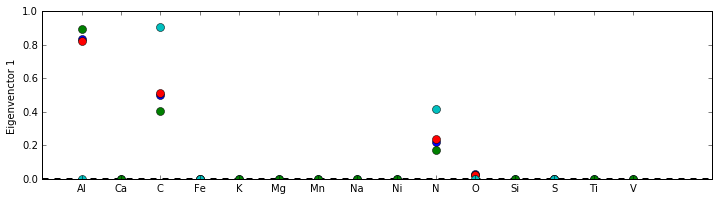

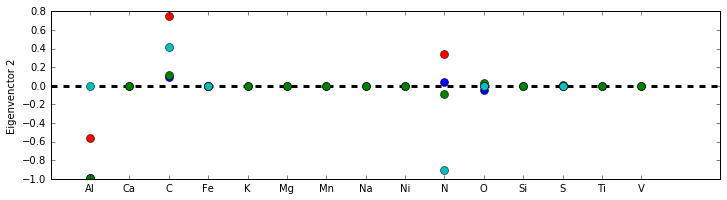

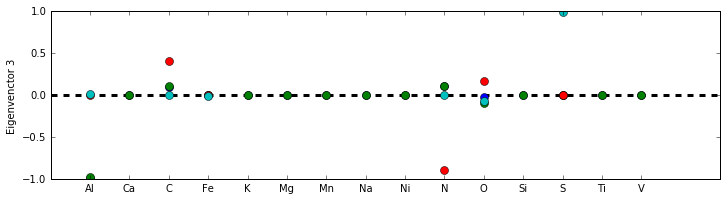

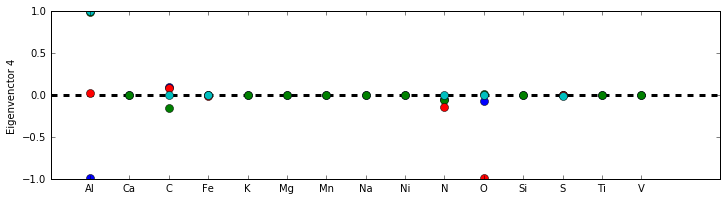

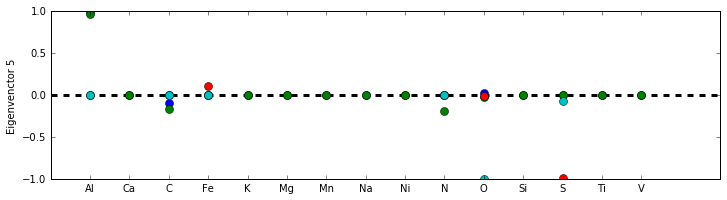

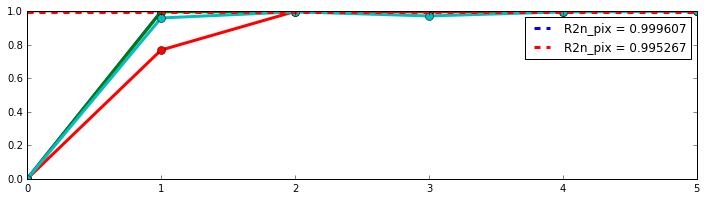

In [102]:
test_run(falsespecs,noise)